# Extraction pass results.
Each extraction pass fine-tune was performed with 30 epochs because of the small dataset size.

In [1]:
import wandb
import matplotlib.pyplot as plt
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification

# General fine-tune.
In this run, model was fine-tuned on combined data from every app.

In [2]:
wandb.login(key='')
hf_token = ''
api = wandb.Api()

project_name = "bert_extraction_ft_2"

runs = api.runs(f"sf-kozlowski-university-of-warsaw/{project_name}")
history = runs[0].history()
history.head()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/gustaw/.netrc
wandb: Currently logged in as: gustaw-blachowski (sf-kozlowski-university-of-warsaw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


,train/loss,train/epoch,eval/I-VALIDITY-TEXT_recall,_step,_runtime,eval/loss,eval/precision,eval/B-ACTIVATION-TEXT_recall,train/global_step,train/grad_norm,...,eval/B-DISCOUNT-TEXT_recall,eval/f1,eval/steps_per_second,eval/I-PRODUCT-NAME_recall,eval/B-VALIDITY-TEXT_recall,eval/runtime,eval/O_recall,eval/overall_accuracy,eval/I-ACTIVATION-TEXT_recall,eval/samples_per_second
0,1.5798,0.022472,NaN,0,3.490569,NaN,NaN,NaN,10,4.711484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.8391,0.044944,NaN,1,3.853799,NaN,NaN,NaN,20,4.231102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0329,0.247191,NaN,10,6.136768,NaN,NaN,NaN,110,0.280066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0178,0.426966,NaN,18,8.185088,NaN,NaN,NaN,190,2.160061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0230,0.494382,NaN,21,8.914566,NaN,NaN,NaN,220,3.276785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training statistics.

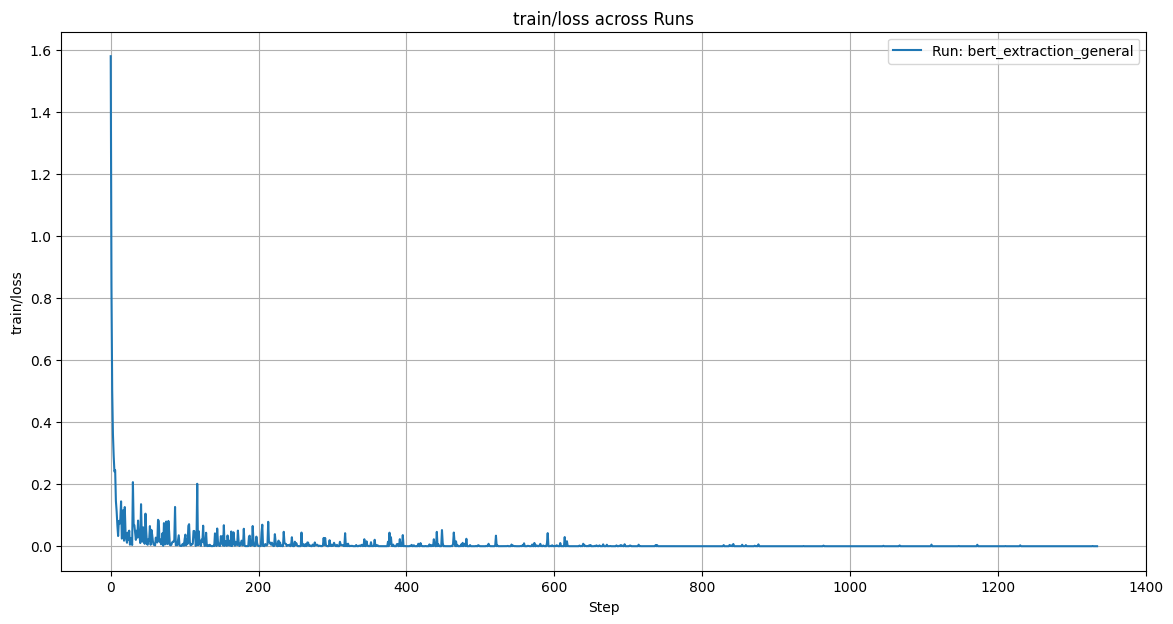

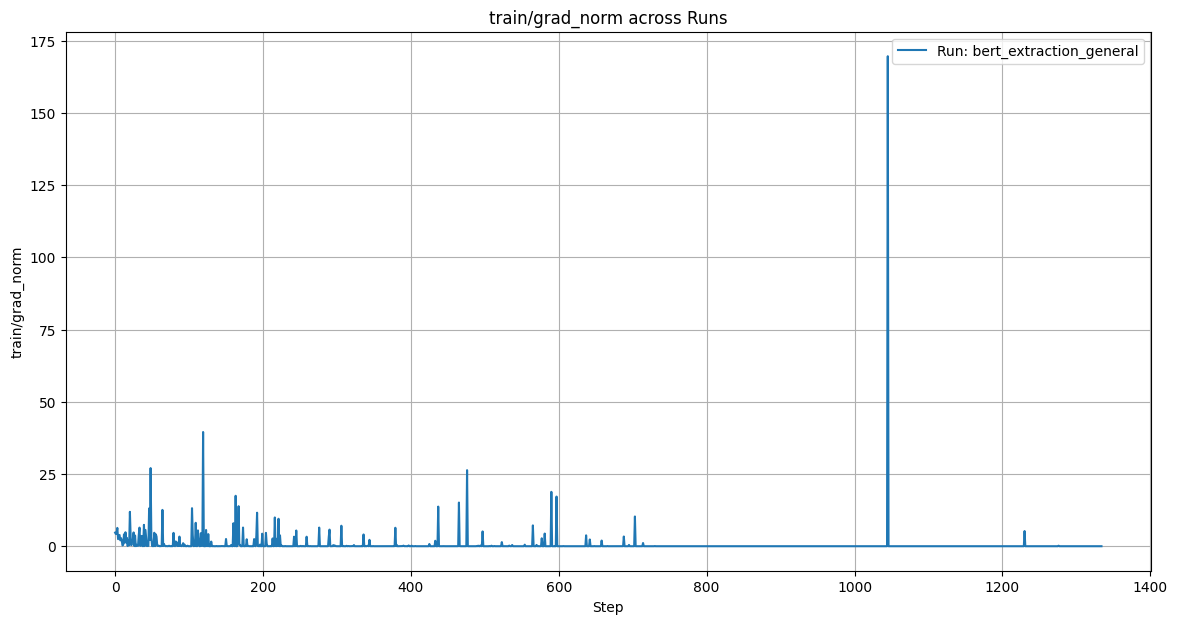

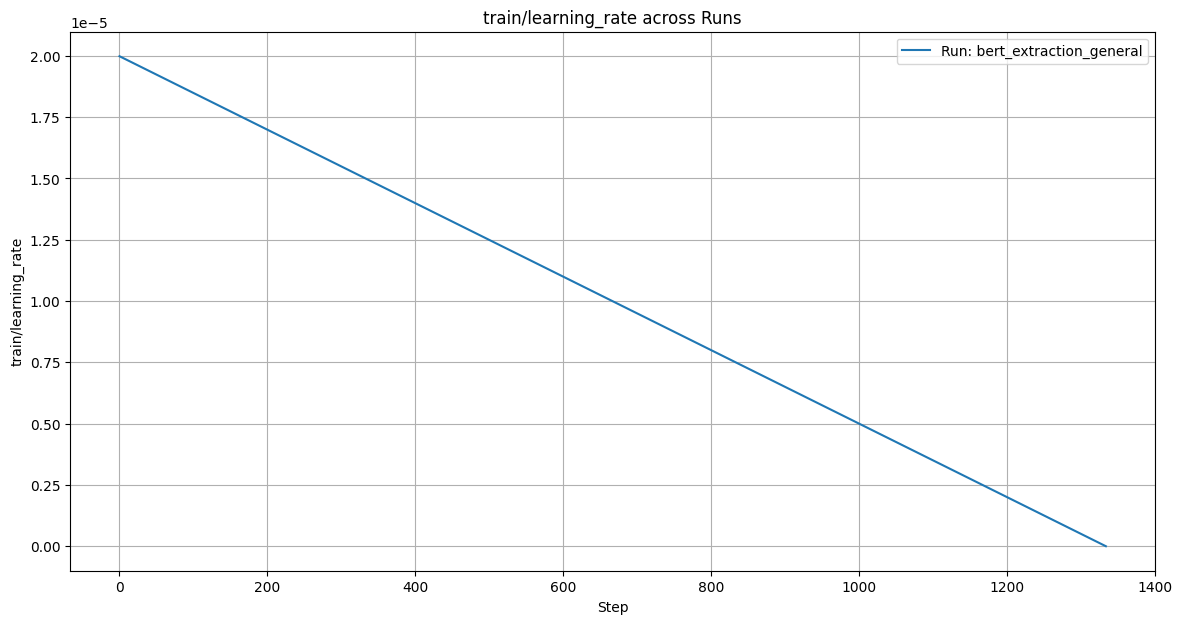

In [3]:
def plot_runs_data(runs, metric):
    plt.figure(figsize=(14, 7))
    for run in runs:
        hist = run.scan_history()
        # Convert to DataFrame
        hist_df = pd.DataFrame(hist)
        if hist_df.empty:
            continue
        if metric in hist_df.columns:
            # Filter out nans
            data = hist_df[metric].dropna()
            labels = list(range(len(data)))
            plt.plot(labels, data, label=f"Run: {run.name}")

    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.title(f"{metric} across Runs")
    plt.legend()
    plt.grid()
    plt.show()

plot_runs_data(runs, "train/loss")
plot_runs_data(runs, "train/grad_norm")
plot_runs_data(runs, "train/learning_rate")

# Evaluation statistics.

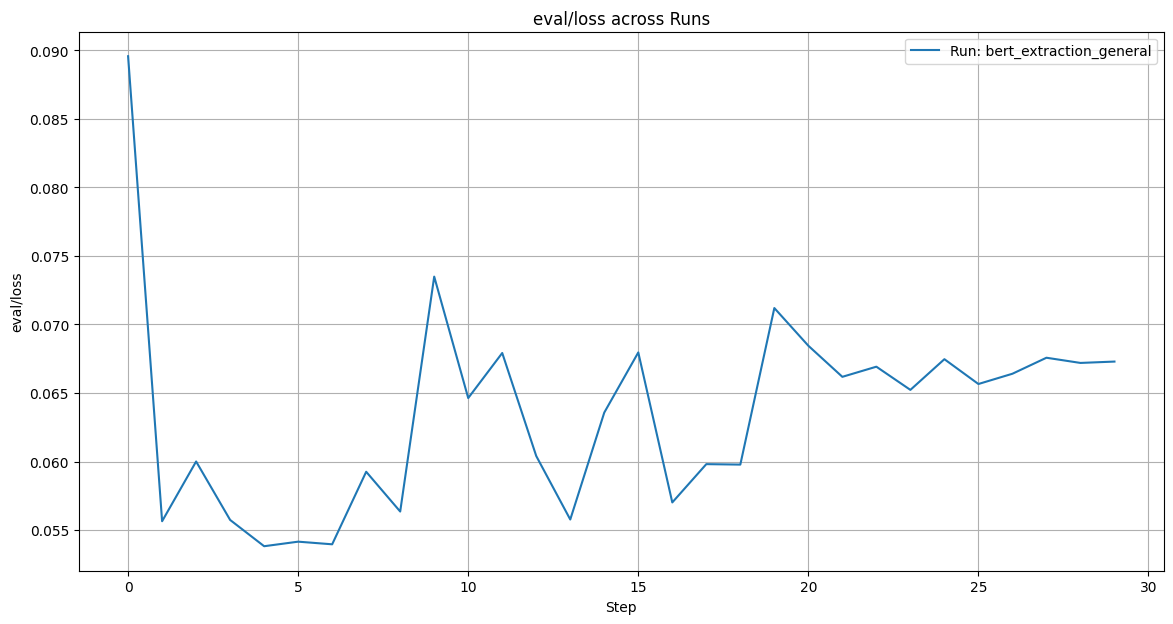

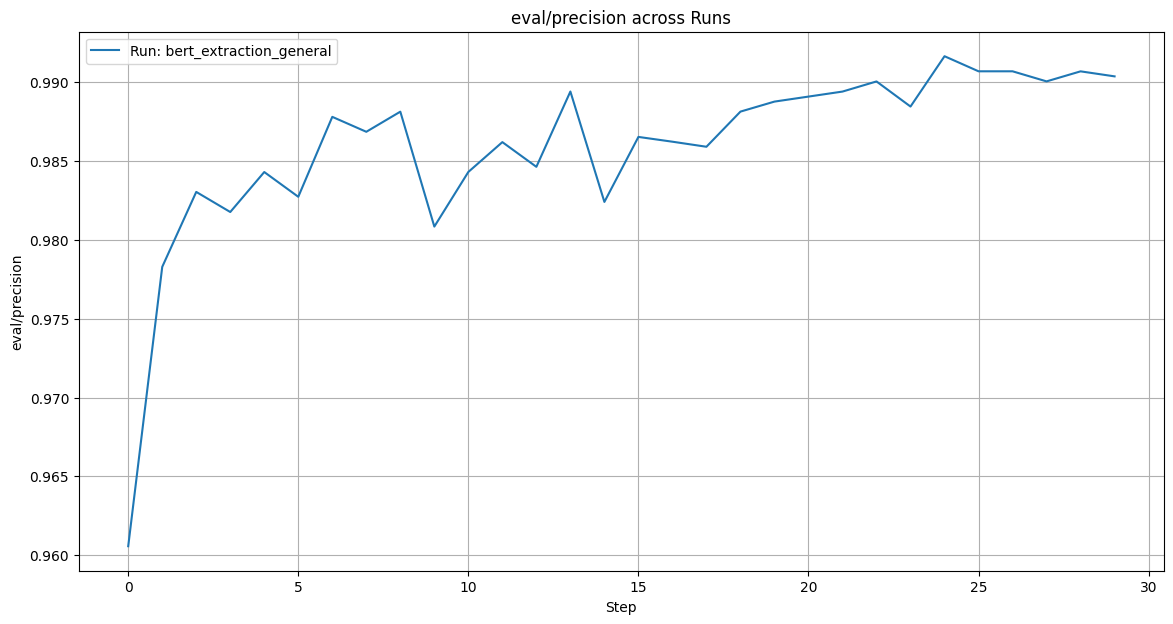

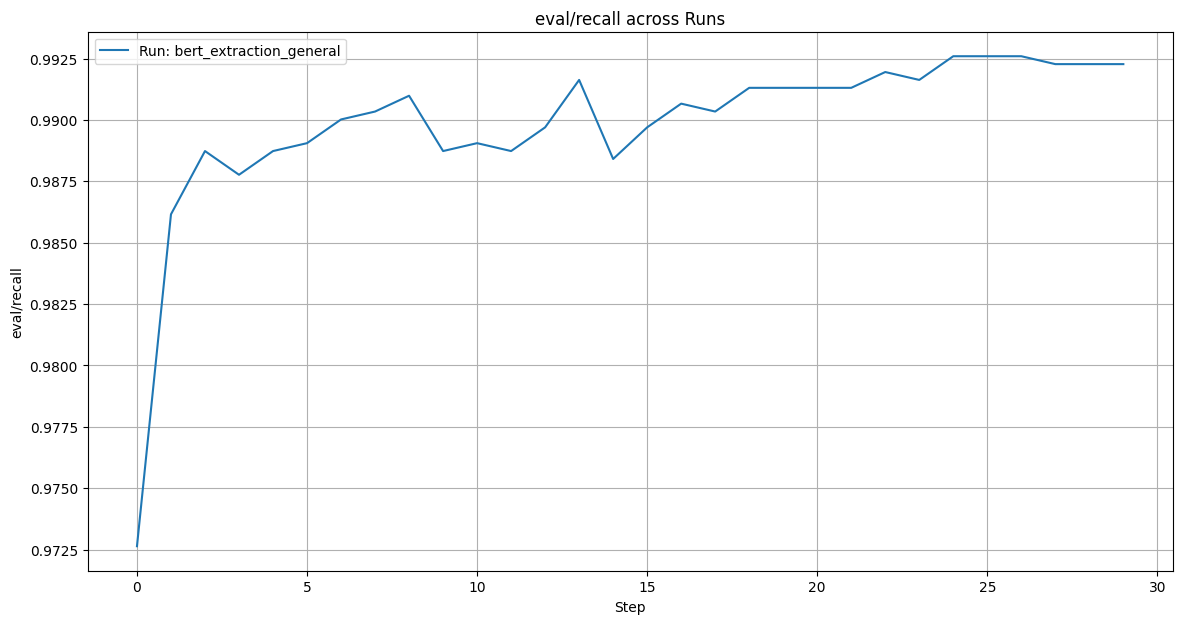

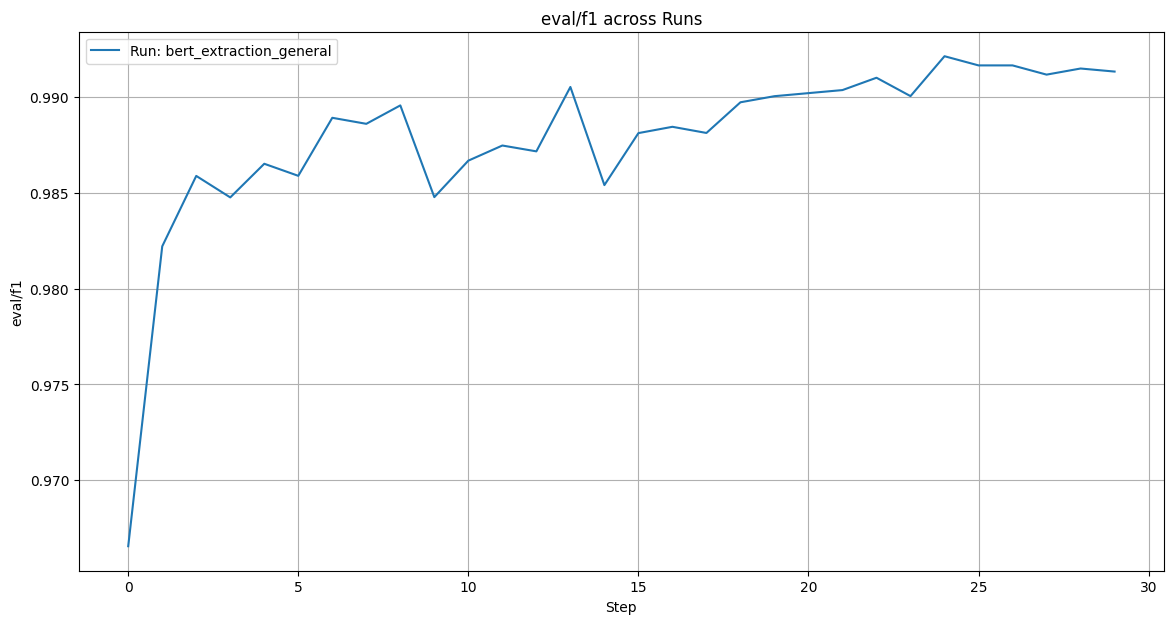

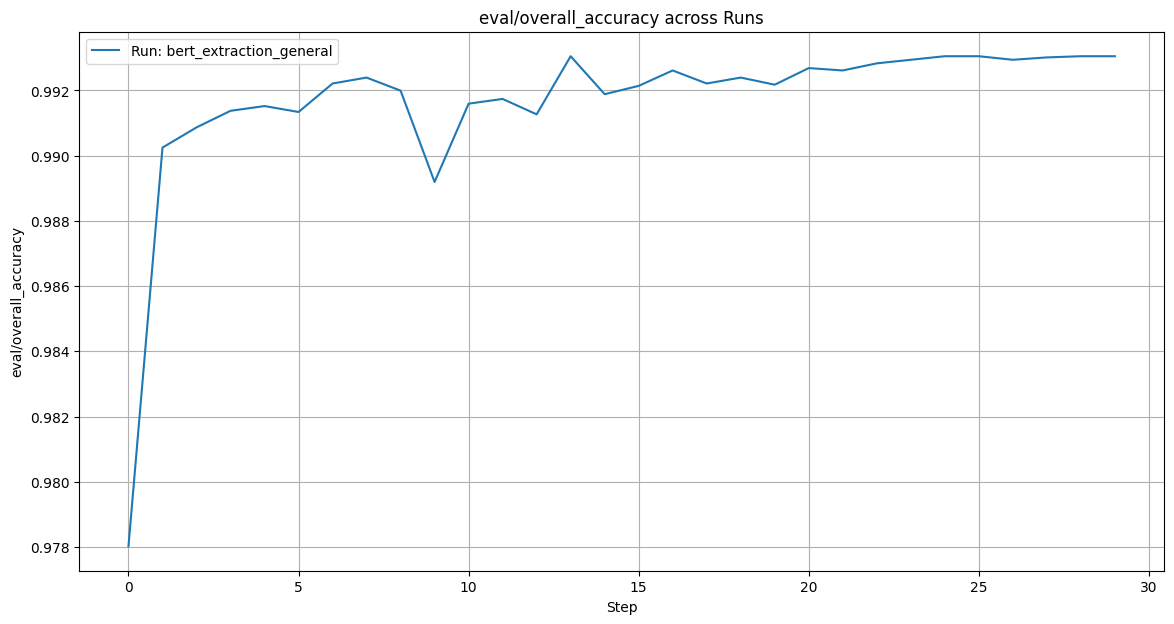

In [4]:
plot_runs_data(runs, "eval/loss")
plot_runs_data(runs, "eval/precision")
plot_runs_data(runs, "eval/recall")
plot_runs_data(runs, "eval/f1")
plot_runs_data(runs, "eval/overall_accuracy")

# Per-app fine-tunings.
Here, separate models were fine-tuned for each app. \
Model name corresponds to the app name. \

In [5]:
project_name = "bert_extraction_single_app_ft"
runs = api.runs(f"sf-kozlowski-university-of-warsaw/{project_name}")

## Training statistics.

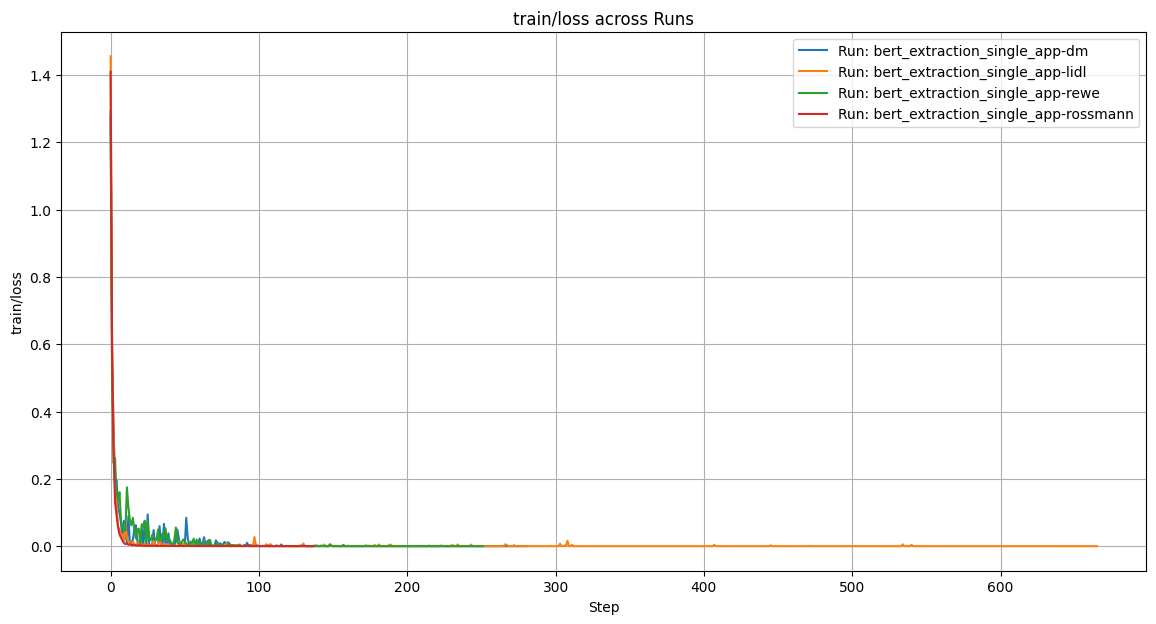

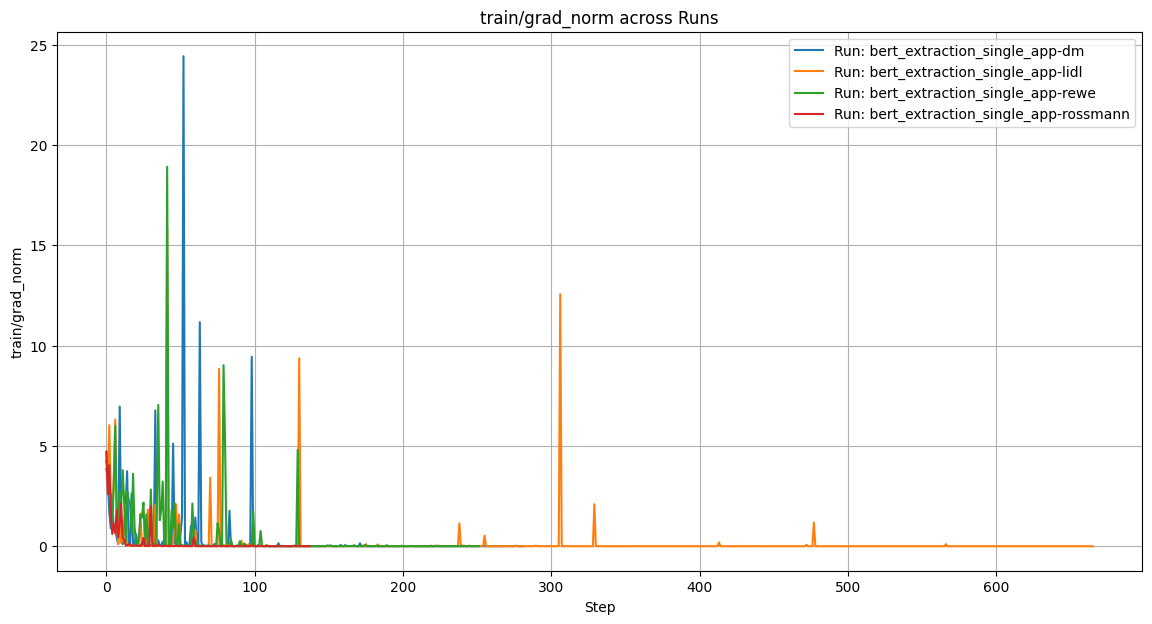

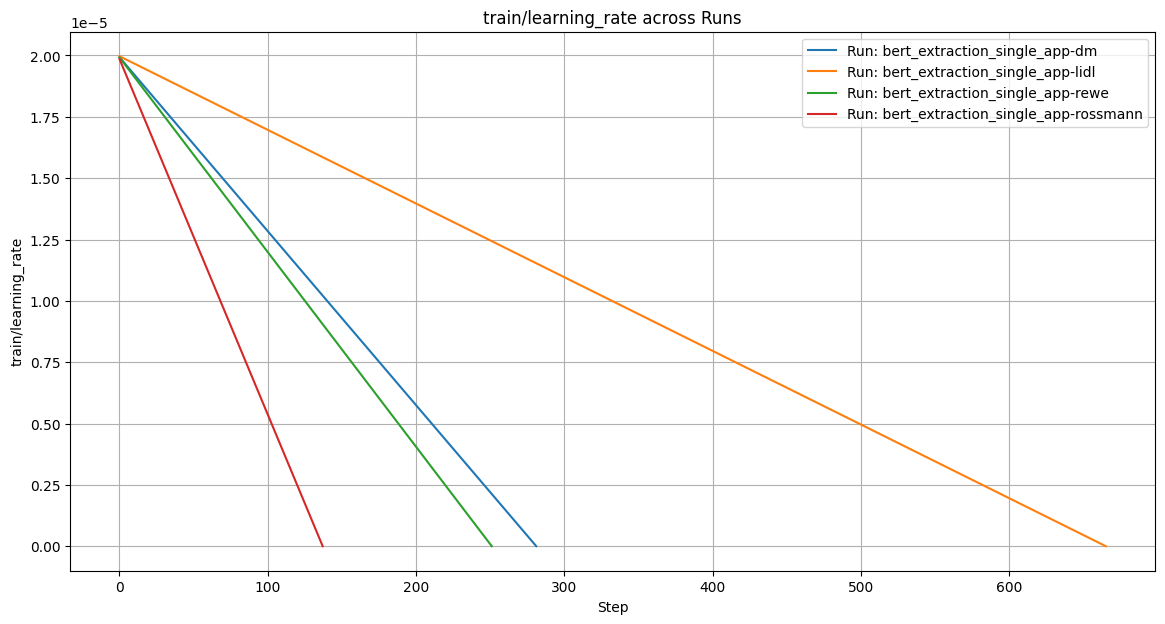

In [6]:
plot_runs_data(runs, "train/loss")
plot_runs_data(runs, "train/grad_norm")
plot_runs_data(runs, "train/learning_rate")

## Evaluation statistics.

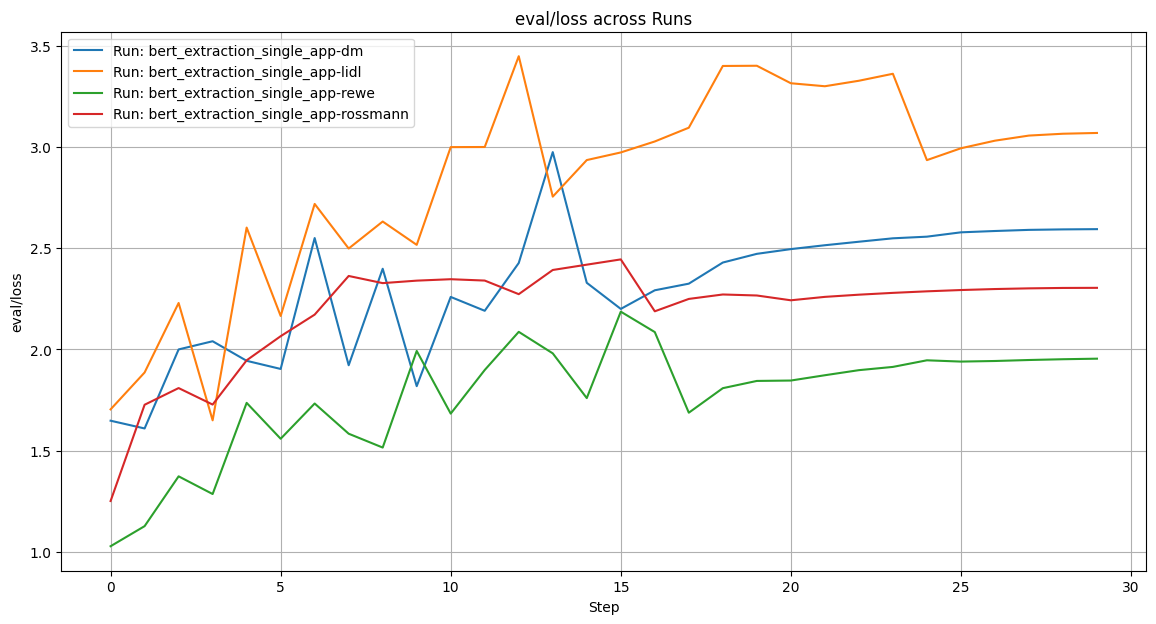

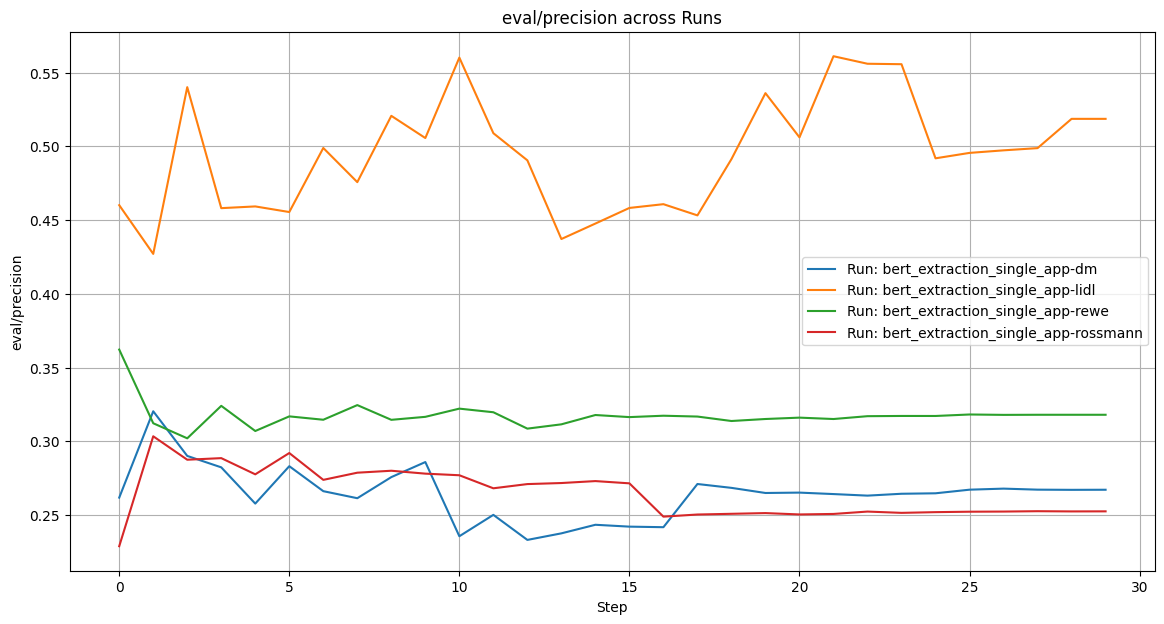

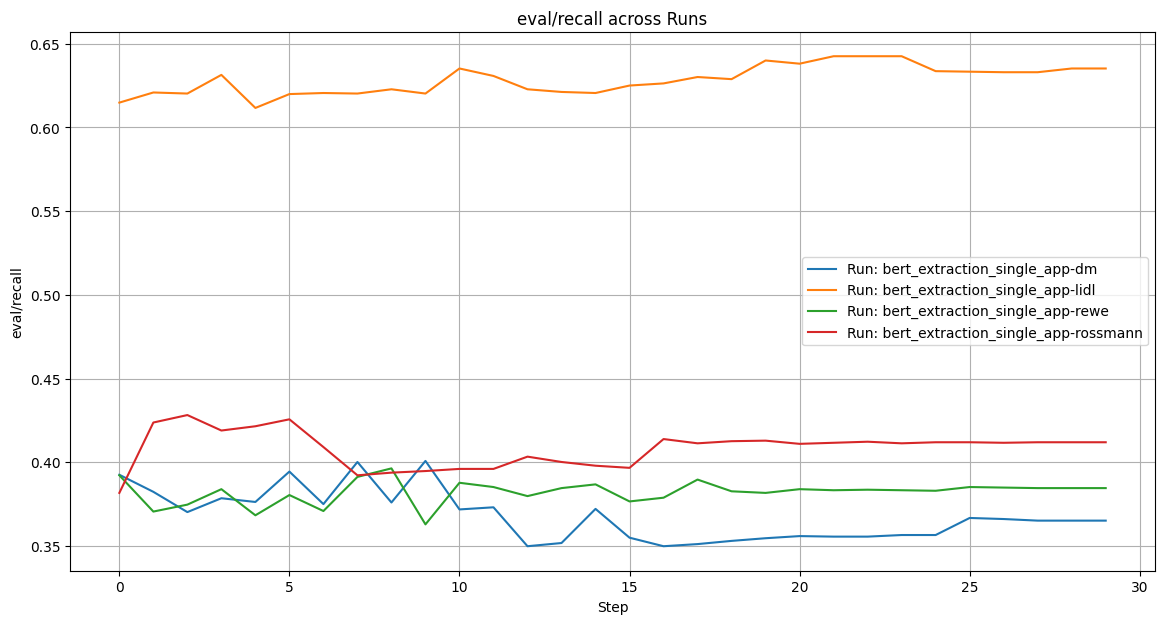

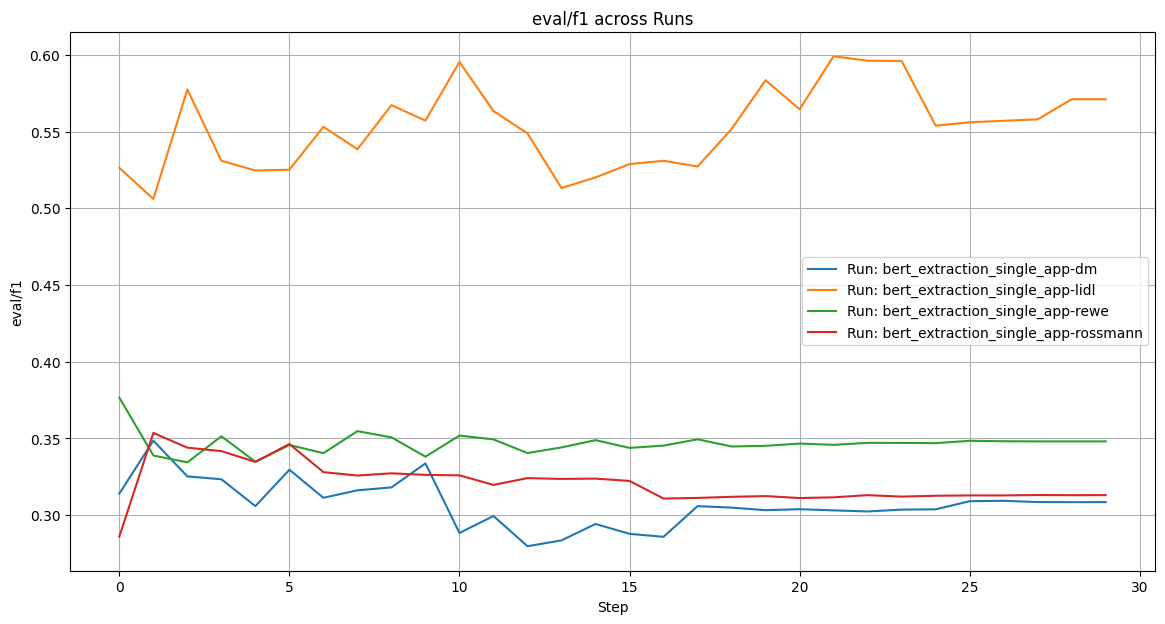

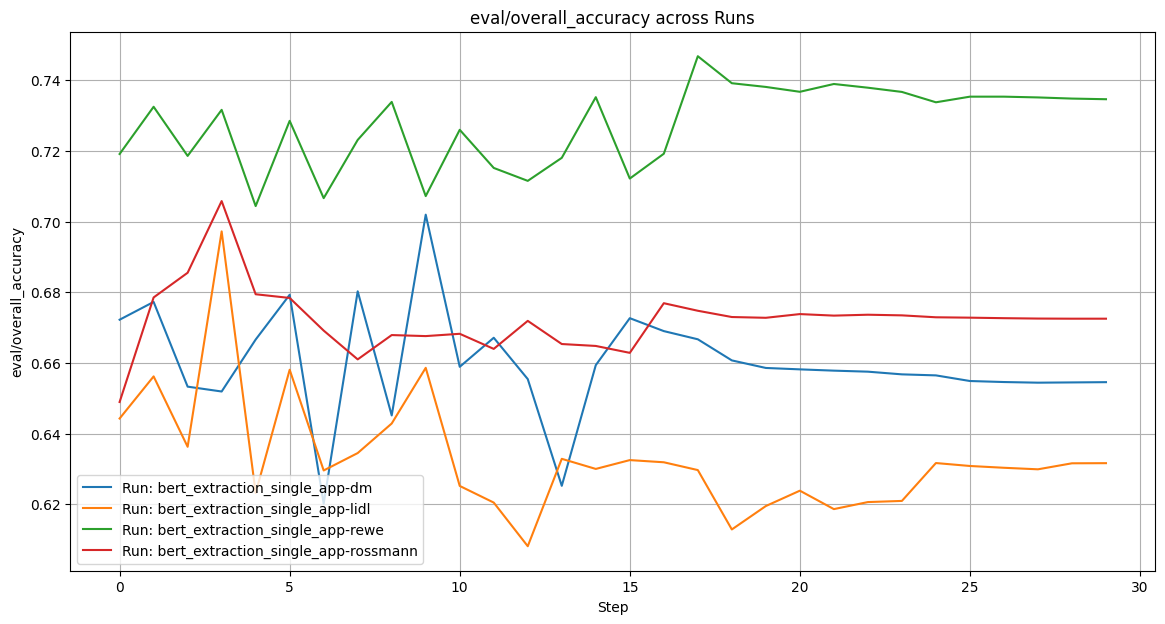

In [7]:
plot_runs_data(runs, "eval/loss")
plot_runs_data(runs, "eval/precision")
plot_runs_data(runs, "eval/recall")
plot_runs_data(runs, "eval/f1")
plot_runs_data(runs, "eval/overall_accuracy")

# Incremental separate fine-tuning.
Here, model was first fine-tuned on the DM app data.
Then the same model was fine-tuned on lidl, rewe and then rossmann apps data. \
Model name corresponds to the last app's name (e.g. rewe means that the model was
fine-tuned on DM, lidl and rewe data).

In [8]:
project_name = "bert_extraction_add_solo_ft"
runs = api.runs(f"sf-kozlowski-university-of-warsaw/{project_name}")

## Training statistics.

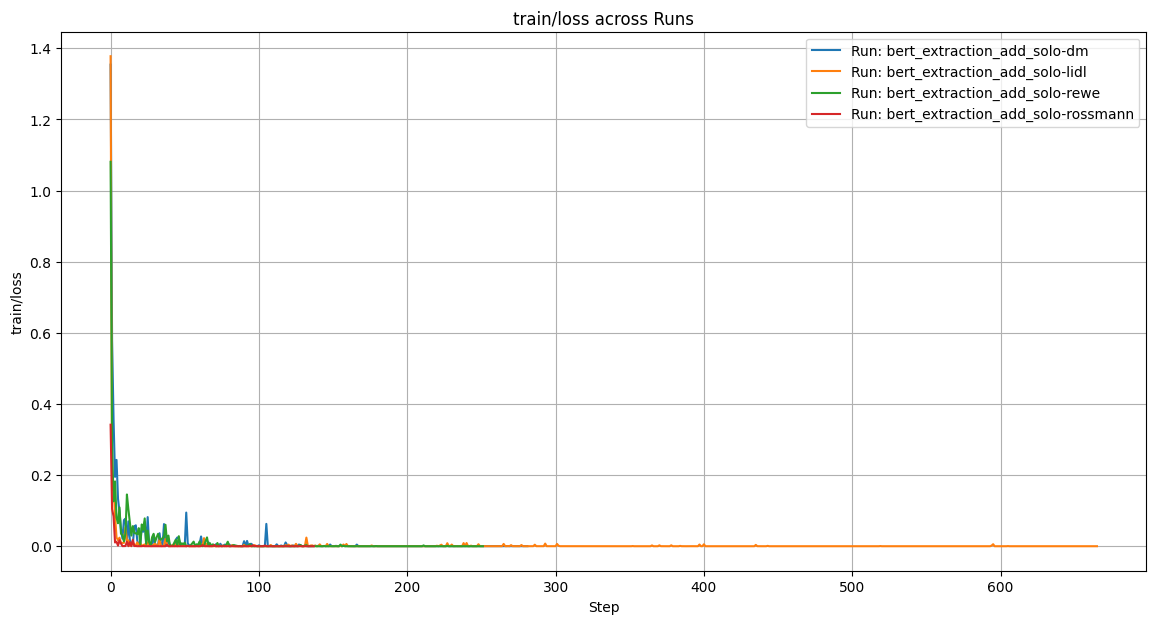

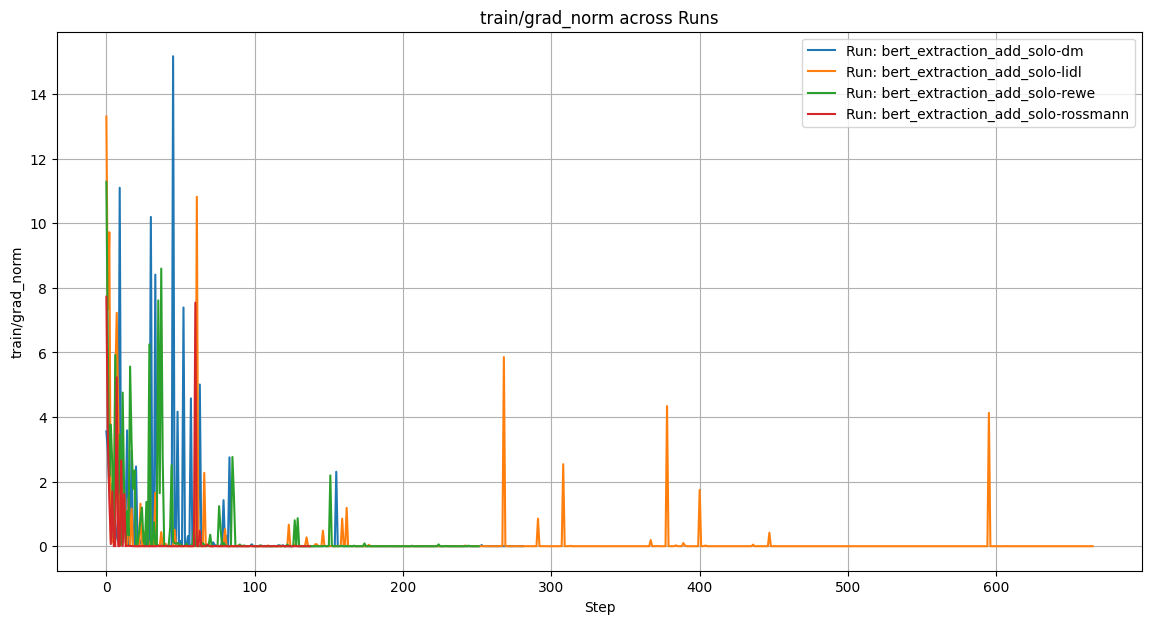

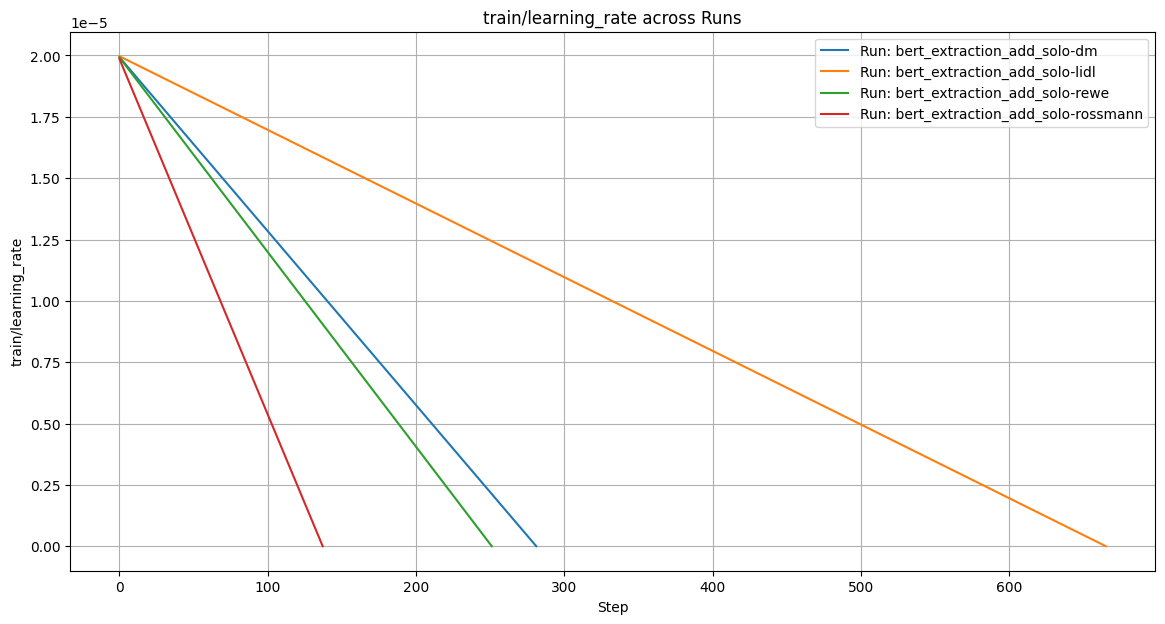

In [9]:
plot_runs_data(runs, "train/loss")
plot_runs_data(runs, "train/grad_norm")
plot_runs_data(runs, "train/learning_rate")

## Evaluation statistics.

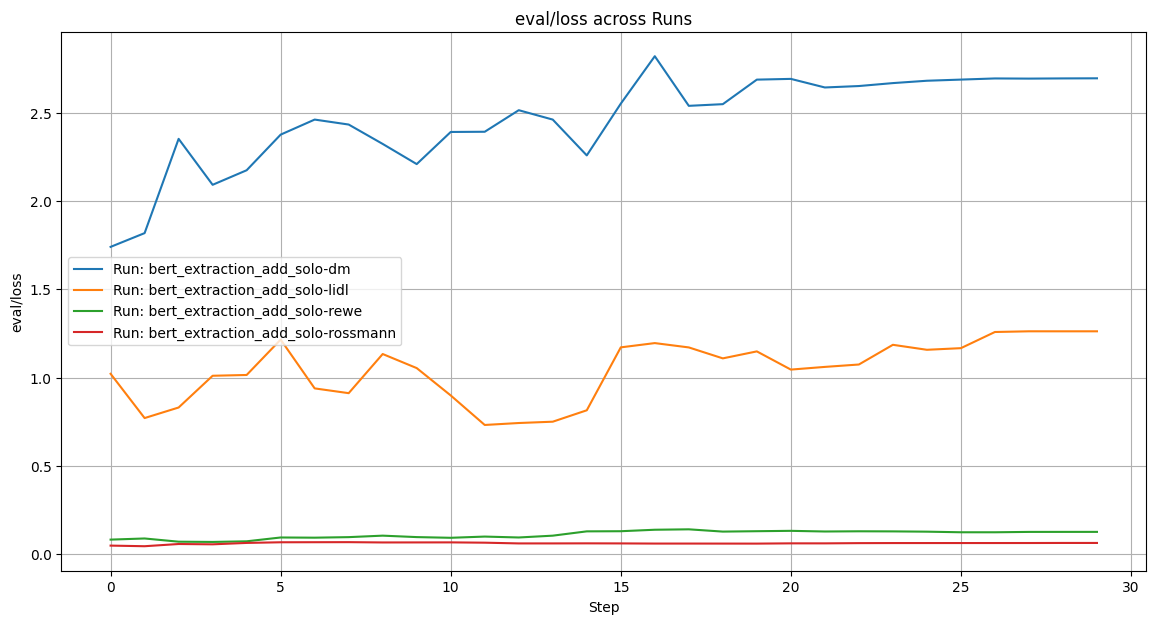

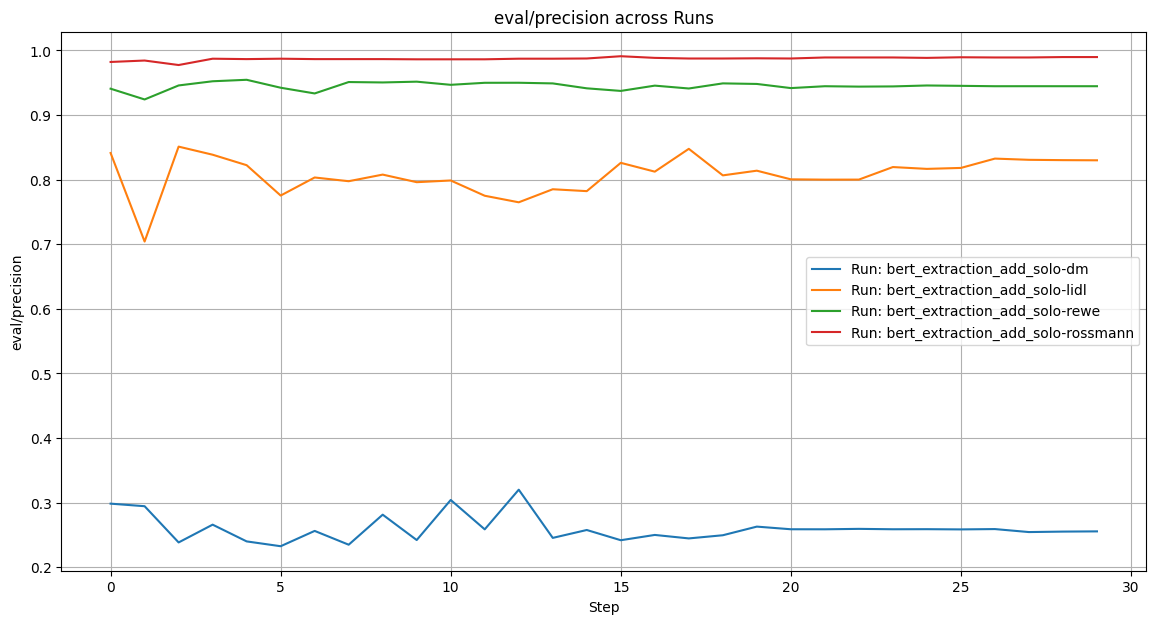

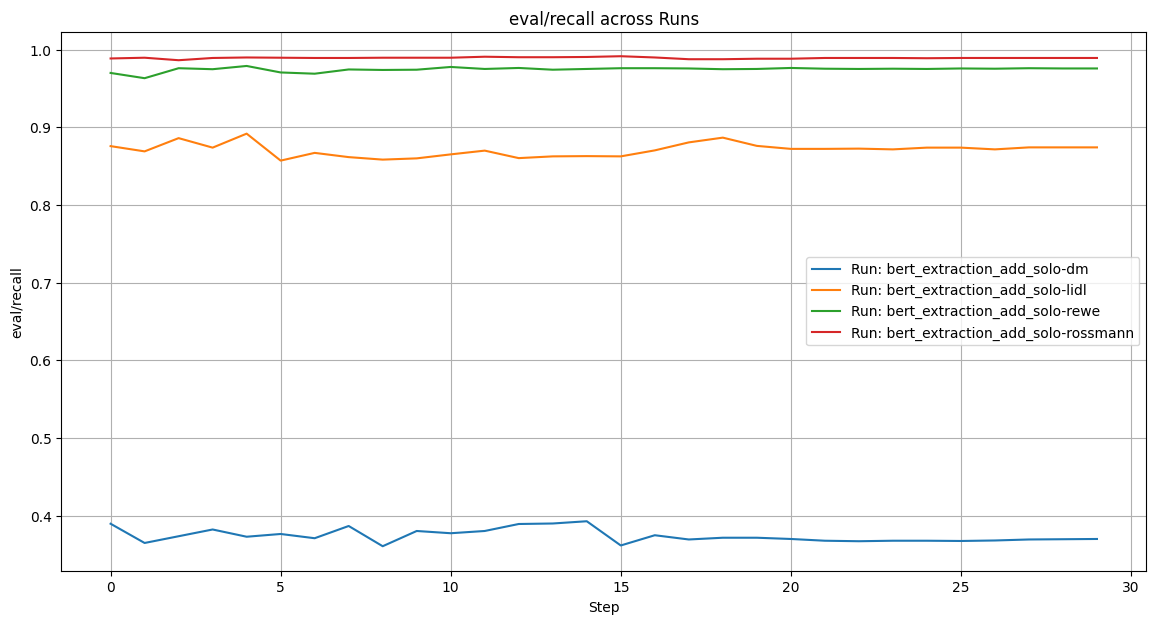

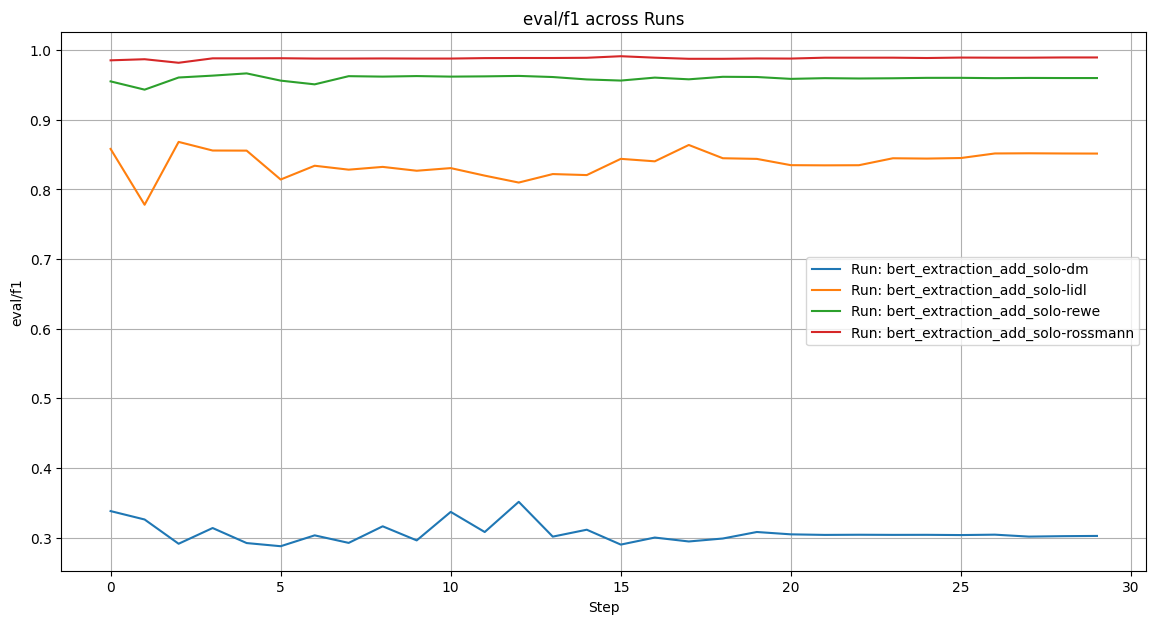

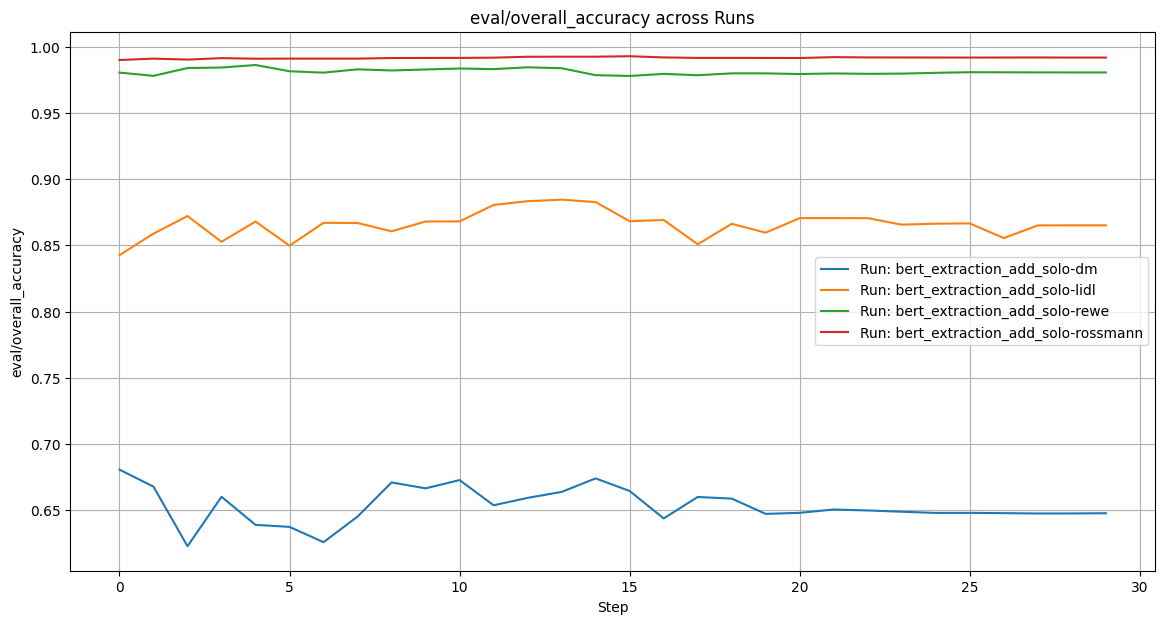

In [10]:
plot_runs_data(runs, "eval/loss")
plot_runs_data(runs, "eval/precision")
plot_runs_data(runs, "eval/recall")
plot_runs_data(runs, "eval/f1")
plot_runs_data(runs, "eval/overall_accuracy")

# Incremental combined fine-tuning.
Here, model was first fine-tuned on the DM app data.
Then the same model was fine-tuned on dm+lidl, dm+lidl+rewe and then dm+lidl+rewe+rossmann apps data. \
Model name corresponds to the name of the last app which data was added to the training set. \

In [11]:
project_name = "bert_extraction_add_grow_ft"
runs = api.runs(f"sf-kozlowski-university-of-warsaw/{project_name}")

## Training statistics.

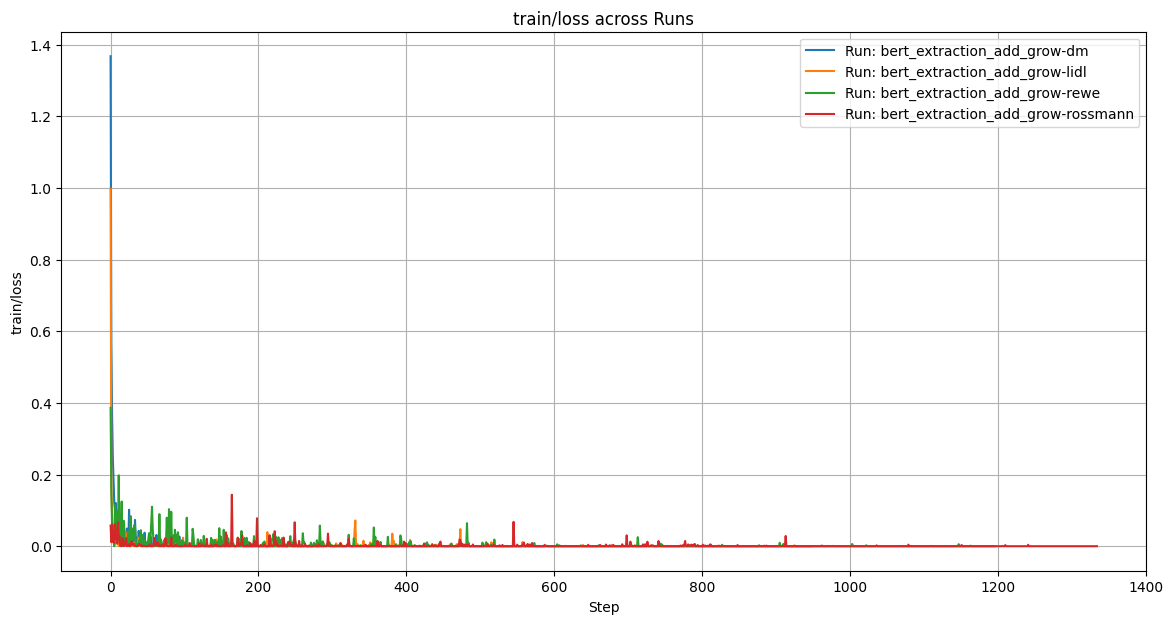

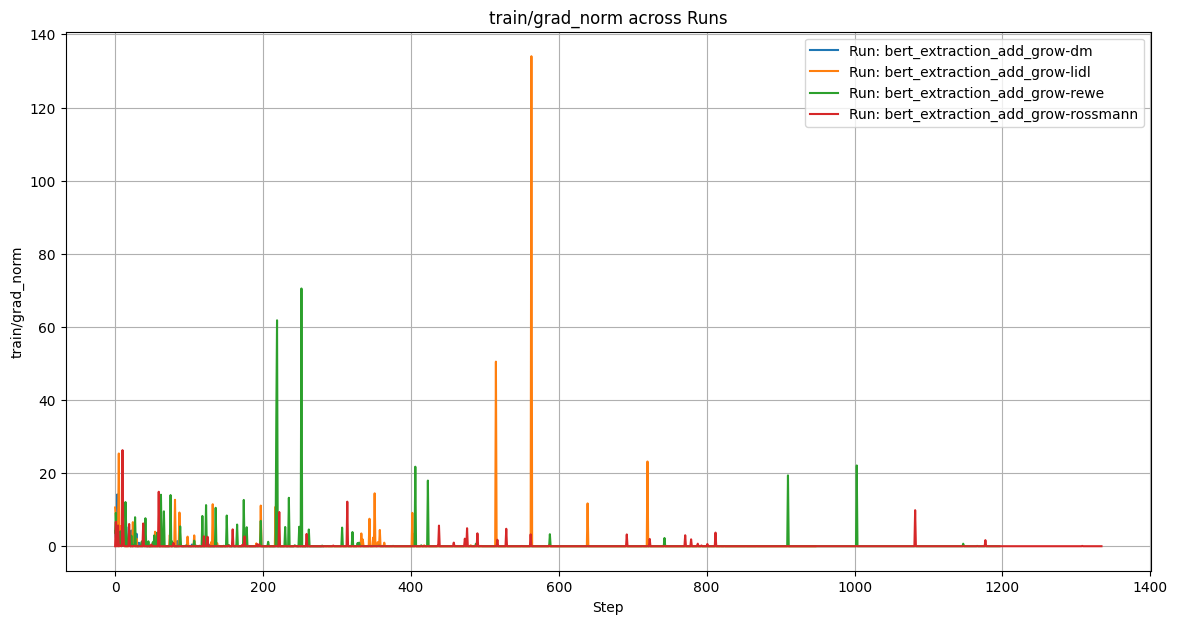

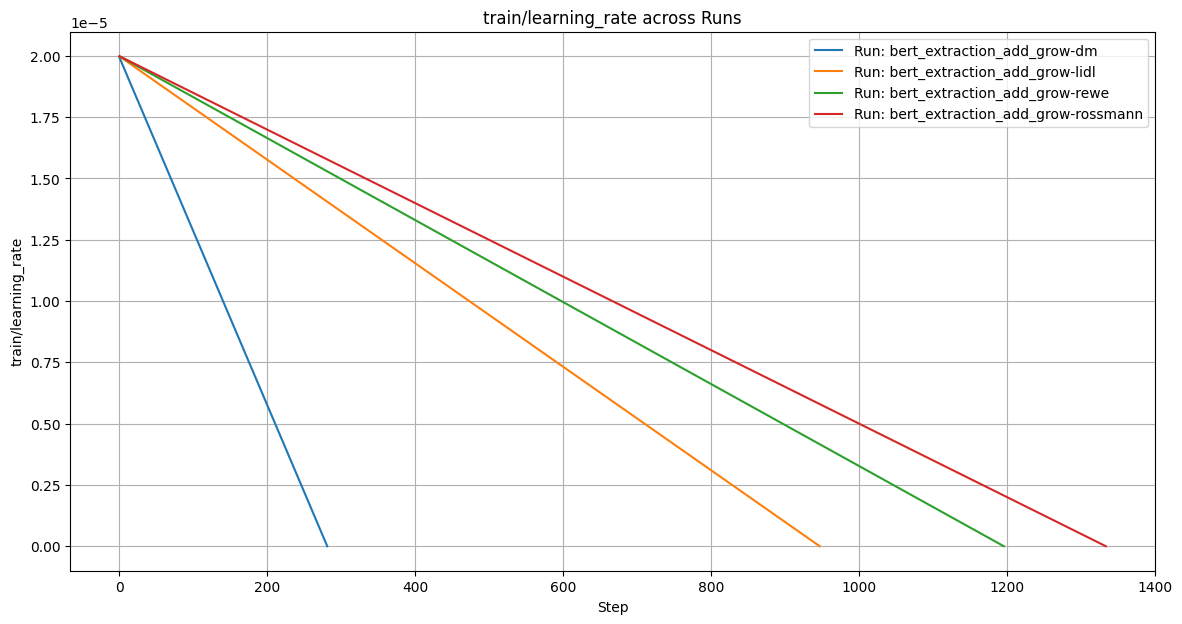

In [12]:
plot_runs_data(runs, "train/loss")
plot_runs_data(runs, "train/grad_norm")
plot_runs_data(runs, "train/learning_rate")

## Evaluation statistics.

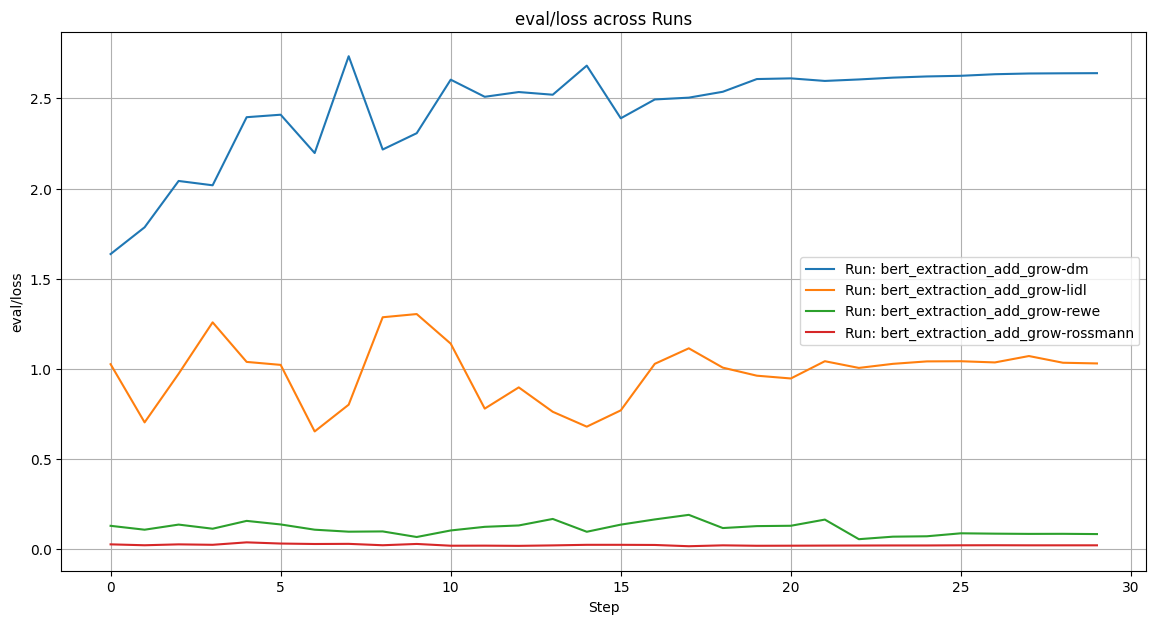

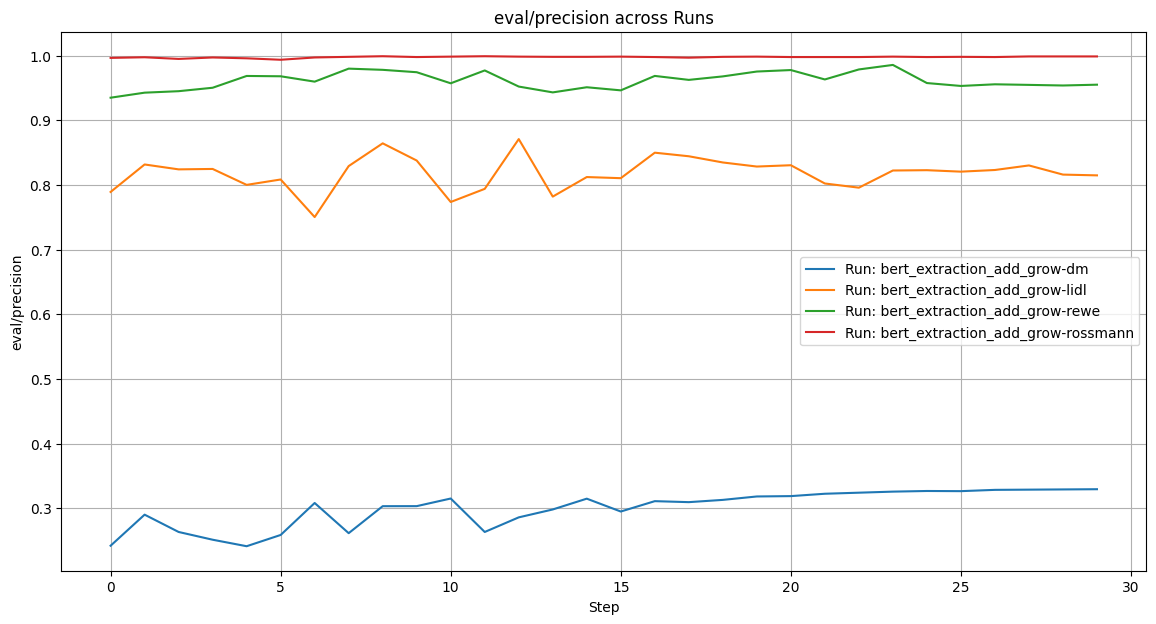

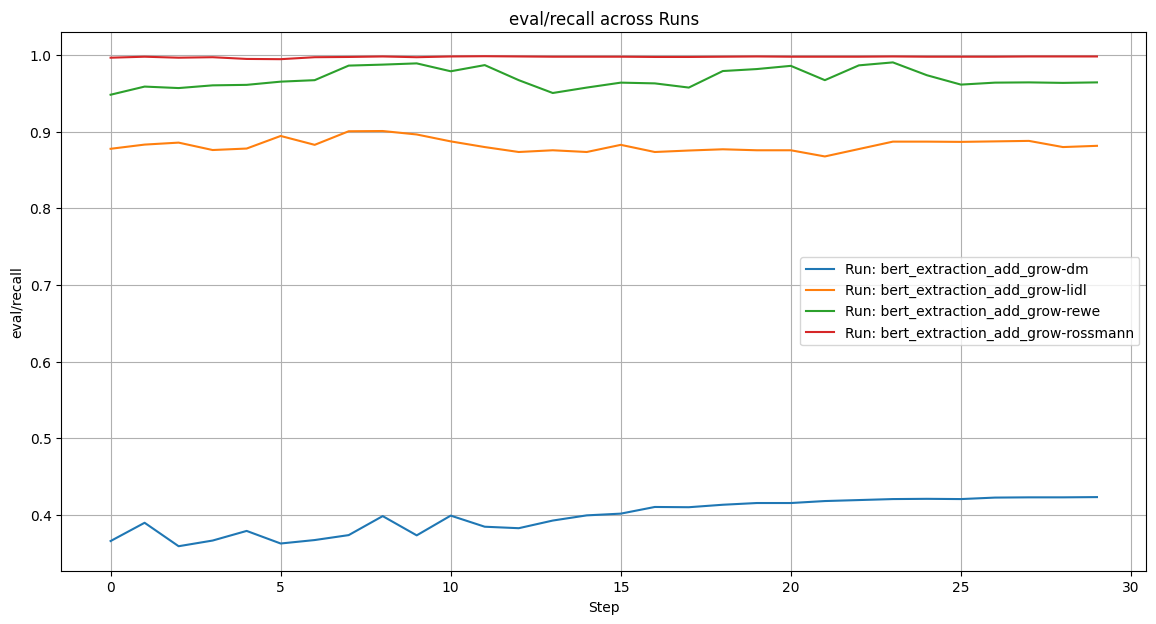

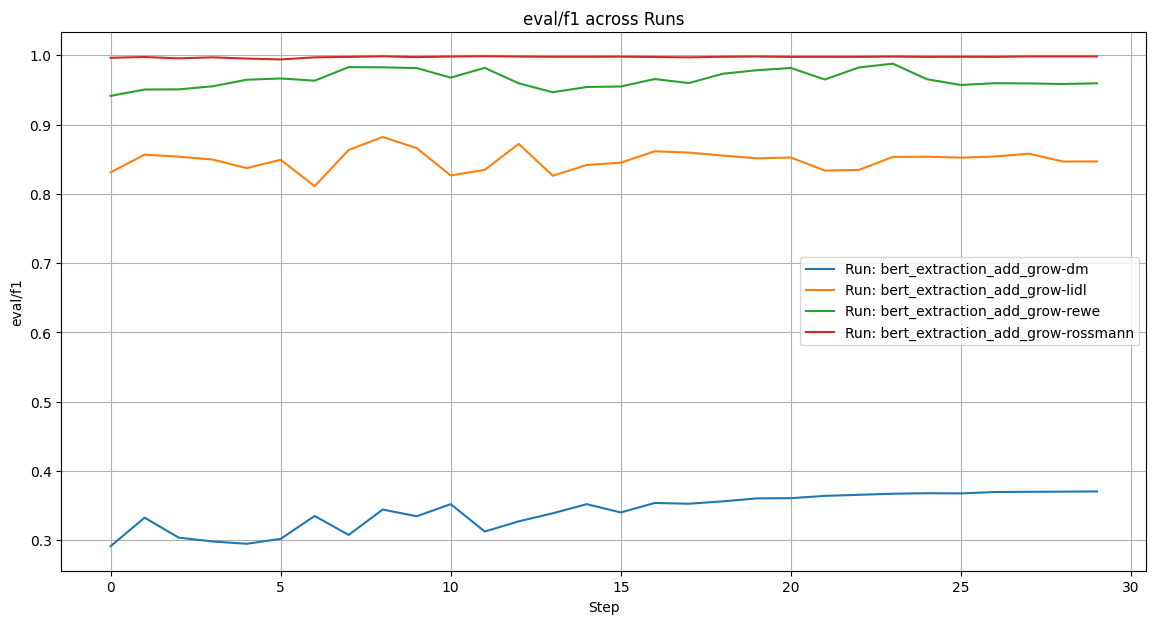

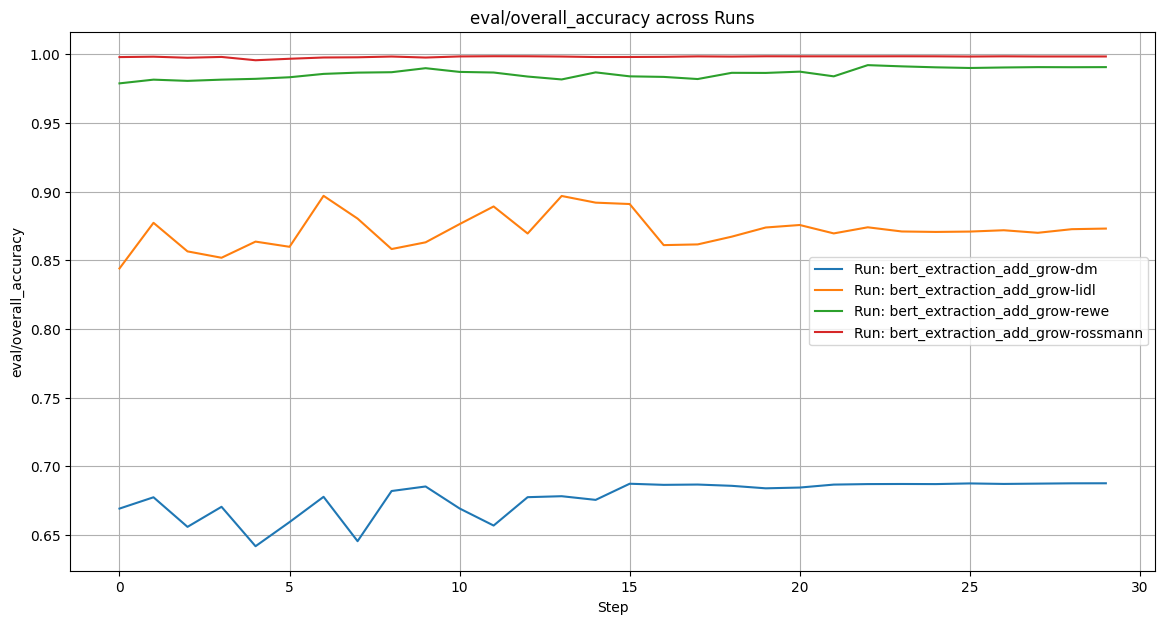

In [13]:
plot_runs_data(runs, "eval/loss")
plot_runs_data(runs, "eval/precision")
plot_runs_data(runs, "eval/recall")
plot_runs_data(runs, "eval/f1")
plot_runs_data(runs, "eval/overall_accuracy")

## Vibe check.
Below I present a proof that the model is indeed working well.

In [14]:
def __align_labels_with_tokens(labels: list, word_ids: list, bi_split: bool) -> list[int]:
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            if not bi_split:
                if label > 0: # If the label is not O or N/A
                    label = 2*label - 1 # Change it to B-XXX
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else: # Same word as previous token
            label = labels[word_id]
            if not bi_split:
                label = 2*label
            else: # Adjust so that one word has only one B-X token.
                if label%2 == 1: # I-X are even; Unknown is even also. B-X is odd.
                    label += 1 # from (2*label)-1 to 2*label
            new_labels.append(label)

    return new_labels

In [15]:
model = AutoModelForTokenClassification.from_pretrained("zpp-murmuras/bert-extraction-rev2", token=hf_token)
dataset = load_dataset("zpp-murmuras/bert-extraction-ds", token=hf_token)
tokenizer = AutoTokenizer.from_pretrained("zpp-murmuras/bert-extraction-rev2", token=hf_token)

sample = dataset['dm']
text_input = sample["texts"][11]
label_input = sample["labels"][11]
print(f"Text data: {text_input}")
print(f"Labels data: {label_input}")


tokenized_input = tokenizer(text_input, is_split_into_words=True, return_tensors="pt")
word_ids = tokenized_input.word_ids(batch_index=0)
prepared_labels = __align_labels_with_tokens(label_input, word_ids, True)
pred2 = model(**tokenized_input)
logits = pred2.logits
predicted_labels = torch.argmax(logits, axis=2)
total = 0
correct = 0
for a, b in zip(prepared_labels, predicted_labels[0]):
    if a == b:
        correct += 1
print(f"Accuracy: {correct/len(prepared_labels)}")

Text data: ['Gültig bis 30.11.2024', 'Gilt für beliebig viele Artikel innerhalb eines Einkaufs', '30%', 'Coupon aktivieren', 'Rasierklingen der Marken BULLDOG, WILKINSON SWORD & WILKINSON Intuition']
Labels data: [5, 0, 3, 7, 1]
Accuracy: 0.967741935483871
